In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

In [2]:
input_file = '/Users/niall/Documents/Cypress_Code/Data/AWGN/noise_data_awgn_snr_zero_final_new.csv'
my_data_flipped = genfromtxt(input_file, delimiter=',')

In [3]:
new_data = np.delete(my_data_flipped, (0), axis=0)

In [35]:
print(len(new_data))

520000


In [4]:
X2 = np.delete(new_data, (0,32), axis=1)

In [5]:
Y2 = new_data[:,32]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [7]:
X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

In [8]:
X_test.shape

(130000, 1, 31)

In [41]:
y_train.shape

(390000,)

# 1. Build LSTM Network 

In [42]:
num_neurons = 31
num_features = 31


model = Sequential()
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=True))
model.add(LSTM(num_neurons, input_shape=(1, num_features), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.summary()

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 31)             7812      
_________________________________________________________________
lstm_5 (LSTM)                (None, 31)                7812      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 32        
Total params: 15,656
Trainable params: 15,656
Non-trainable params: 0
_________________________________________________________________
inputs:  (None, 1, 31)
outputs:  (None, 1)
actual inputs:  (390000, 1, 31)
actual outputs:  (390000,)


In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='rmse', optimizer='adam', metrics=['accuracy'])

In [45]:
print('Training LSTM...')

batch_size = 5

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

Training LSTM...
Train on 390000 samples, validate on 130000 samples
Epoch 1/5
390000/390000 [==============================] - 297s 763us/sample - loss: 0.0122 - acc: 0.9960 - val_loss: 0.0093 - val_acc: 0.9968
Epoch 2/5
390000/390000 [==============================] - 292s 749us/sample - loss: 0.0079 - acc: 0.9972 - val_loss: 0.0085 - val_acc: 0.9972
Epoch 3/5
390000/390000 [==============================] - 292s 749us/sample - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0086 - val_acc: 0.9972
Epoch 4/5
390000/390000 [==============================] - 304s 780us/sample - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0087 - val_acc: 0.9975
Epoch 5/5
130000/130000 [==============================] - 36s 278us/sample - loss: 0.0087 - acc: 0.9973 - loss: 0.0087 -  - ETA: 0s - loss: 0.0087 - acc: 


In [46]:
print('score:', score)
print('accuracy:', acc)

score: 0.008722918335468382
accuracy: 0.9972692


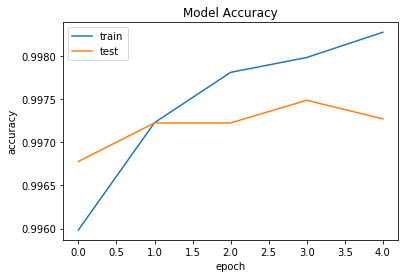

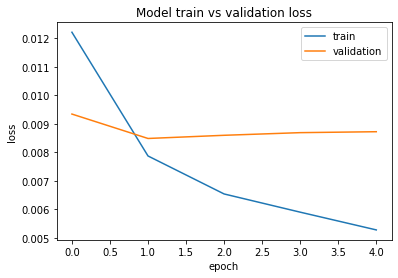

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
# Let's save the model to disc
json = model.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snrzero.json", "w") as file:
    file.write(json)
model.save_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snrzero.h5")
print("Saved model to disc")

Saved model to disc


In [9]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snrzero.json', 'r')
json = json_file.read()
json_file.close()
model_one_from_disc = model_from_json(json)
model_one_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/LSTM/AWGN_Models/model_one_snrzero.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
y_pred_from_disk = model_one_from_disc.predict(X_test, batch_size=1, verbose=1)

130000/130000 [==============================] - 118s 906us/sample


In [54]:
pred = pd.DataFrame(y_pred_from_disk, columns =['Y_pred']) 
pred['Label'] = y_test

In [55]:
pred.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/LSTM/AWGN/model_one_snrzero.csv', index = False)

In [12]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
preds_new = model_one_from_disc.predict_classes(X_test)
metrics(preds_new, y_test)

F1-score:  0.9971621567608617
Precision:  0.9973933762973151
Recall:  0.9969310444039513
Acuracy:  0.9972692307692308
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67438
           1       1.00      1.00      1.00     62562

    accuracy                           1.00    130000
   macro avg       1.00      1.00      1.00    130000
weighted avg       1.00      1.00      1.00    130000

